In [2]:
import numpy as np
from IPython.display import Image

# Project Molecular Dynamics

# 1. Structure

## 1.1 General Structure

Include simple picture of structure here

## 1.2 Input file

In [1]:
import numpy as np
# Fill these before you start the Simulation

#Substance to be simulated e.g NaCl 
Symbols = np.array(['Na','Cl'])

#Stochiometric Coefficients e.g. Na_1_Cl_1
Coefficients = np.array([1,1])

#Atomic Charges e.g. Na_1+_Cl_1-
Charges = np.array([1.0 ,-1.0])

#Number of Particles
N = 32

#Boxsize
L_x=2.256e-09
L_y=2.256e-09
L_z=2.256e-09


#LJ Cutoff Radius
r_cut_LJ = 0.4*L_x
assert r_cut_LJ < L_x/2 "LJ cutoff radius must be smaller than half the boxlength"

#Short-Range Potential Cutoff Radius
r_cut_coulomb = 2*L_x

#Accuracy Factor, the cutofferror is given by exp(-p)
p_error = 10.0

#Temperature 
T = 100 # Kelvin 

#Timestep
dt = 1e-16 # .1 fs

#Characetristic coupling time for Thermostat, must be larger than dt
tau = 1e-13
assert tau>dt, "tau must be larger than dt"

#Switch Radius
r_switch = r_cut_LJ*0.9
assert r_switch < r_cut_LJ, "switch radius must be smaller than LJ cutoff Radius"

# !!!  DO NOT CHANGE THESE LINES  !!!

# Summarizing Dimension in one array
L = np.array([L_x, L_y, L_z])

#Reassignment Probability
p_rea = dt/tau

#number of Boxes to consider for LJ-Potential
n_boxes_LJ = np.ceil(r_cut_LJ/np.max(L)).astype(int) 

## 1.3 Class "System"

- get_Labels(self)


- get_LJ_parameter(self)

## 1.4 Class "md"

### Functions available for user

- get_neighbourlist_coulomb(self)


- get_neighbourlist_LJ(self)


- get_potential(self)


- get_energy(self)


- get_forces(self)


- get_Temperature(self)


- propagate_system(self)


- get_traj(self, N_steps, Energy_save, Temperature_save, Frame_save, path)


- minmimize_Energy(self, N_steps, threshold, Energy_save, Frame_save, constant, path)

## 1.5 Class "neighbourlist"

- compute_neighbourlist(self, R, box_length, r_cutoff)

Function returns list of neighbors within the cutoff radius for all particles:

In [1]:
def compute_neighbourlist(R, box_length, r_cutoff):
    neighbors = {}
    distances = {}
    N, dim = np.shape(R)
    # divide simulation box into small cells of equal size r_c >= r_cutoff
    # (assume same size in all N dimensions)
    n_cells = np.int(box_length / r_cutoff)
    r_c = box_length / n_cells
    head = [-1] * (n_cells)**3
    cllist = [-1] * N
    for i in range(N):
        #empty list of neighbors
        neighbors[i] = []
        distances[i] = []
        # cell index of particle by its position
        x = np.int(R[i][0] / r_c)
        y = np.int(R[i][1] / r_c)
        z = np.int(R[i][2] / r_c)
        cell_index = x*n_cells*n_cells + y*n_cells + z
        cllist[i] = head[cell_index]
        # The last one goes to the head
        head[cell_index] = i
        
        # For all cells: Look for neighbors within neighboring cells
        for cell in range(n_cells**3):
            x = np.int(cell/(n_cells*n_cells)) % n_cells
            y = np.int(cell/n_cells) % n_cells
            z = cell % n_cells
            
            nb = np.empty(3)
            r_shift = np.empty(3)
            # Scan the neighboring cells (including itself)
            nb[0] = x-1
            nb[1] = y-1
            nb[2] = z-1
            for nbcell_ind in range(3**3):
                if nbcell_ind != 0:
                    nb[2] += 1
                    if nbcell_ind % 3 == 0:
                        nb[2] = z-1
                        nb[1] += 1
                    if nbcell_ind % 9 == 0:
                        nb[1] = y-1
                        nb[0] += 1

                # Shift image position of simulation box?
                for d in range(3):
                    if (nb[d] < 0):
                        r_shift[d] = -box_length
                    elif (nb[d]>=n_cells):
                        r_shift[d] = box_length
                    else:
                        r_shift[d] = 0.0
                  
                # Calculate cell index nbcell of neighbor cell
                nbcell = np.int(((nb[0]+n_cells)%n_cells)* n_cells*n_cells
                          + ((nb[1]+n_cells)%n_cells) * n_cells 
                          + ((nb[2]+n_cells)%n_cells))
                # where % pulls index back into appr. range

                # Scan particle i in cell 
                i = head[cell]
                while(i != -1):
                # Scan particle j in cell nbcell
                    j = head[nbcell]
                    while(j != -1):
                    # Avoid double counting of pair (i, j)
                        if (i<j):
                            # dist of i, j smaller than cutoff?
                            dist = np.linalg.norm(R[i]-(R[j]+r_shift))
                            if (dist <= r_cutoff):
                                neighbors[i].append(j)
                                distances[i].append(dist)
                                neighbors[j].append(i)
                                distances[j].append(dist)


                        j = cllist[j]
                    i = cllist[i]
                                    
        return neighbors, distances

In [2]:
def naive_neighborlist(R, box_length, r_cutoff):
    naiveneighbors = {}
    distances = {}
    dx = np.empty(3)
    for i in range(N):
        naiveneighbors[i] = []
        distances[i] = []
        for j in range(N):
            d = 0.0
            for x in range(3):
                dx[x] = R[i][x]-R[j][x]
                if (dx[x] < -box_length/2):
                    dx[x] += box_length
                elif (dx[x] > box_length/2):
                    dx[x] -= box_length
                    
                d += dx[x]**2
            d = np.sqrt(d)
            if (d <= r_cutoff):
                if (i>j):
                    naiveneighbors[i].append(j)
                    distances[i].append(d)
                    naiveneighbors[j].append(i)
                    distances[j].append(d)

    return naiveneighbors, distances

In [3]:
import numpy as np
import time
N = 300
R = np.random.rand(N,3)
box_length = 1.0
r_cutoff = 0.11

a = time.clock()
n1, dist1 = compute_neighbourlist(R, box_length, r_cutoff)
b = time.clock()
print("cell list: ", str(b-a), "seconds")

c = time.clock()
n2, dist2 = naive_neighborlist(R, box_length, r_cutoff)
d = time.clock()
print("naive impl.: ", str(d-c), "seconds")

('cell list: ', '0.278773', 'seconds')
('naive impl.: ', '1.018657', 'seconds')


## 1.6 Class "directions"

- get_directions(self, n_boxes)

In [8]:
def get_directions(n_boxes):
    """ Returns
    -------------------
    K (2*n_boxes+1)**3 x 3 Array
    Each Row of the Array denotes a 1x3 Array that points to a unique dircetion"""
        
    assert type(n_boxes) is int, "n_boxes must be an integer"
    # number of boxes in system (including all copies)
    N_total_boxes = (2*n_boxes+1)**3
    
    # create natural numbers starting from 0 in decimal system
    decimals = np.arange(N_total_boxes)
    
    # convert natural numbers to q-adic representation
    base = (2*n_boxes+1)

    K = np.zeros((N_total_boxes,3))

    K[:,0] = np.floor(decimals/base**2)                      # q²
    K[:,1] = np.floor((decimals - K[:,0]*base**2) / base)    # q¹
    K[:,2] = decimals - K[:,0]*base**2 - K[:,1]*base         # q⁰

    K -= n_boxes       # highest coefficient is number of boxes in one direction
    return K

In [9]:
get_directions(1)

array([[-1., -1., -1.],
       [-1., -1.,  0.],
       [-1., -1.,  1.],
       [-1.,  0., -1.],
       [-1.,  0.,  0.],
       [-1.,  0.,  1.],
       [-1.,  1., -1.],
       [-1.,  1.,  0.],
       [-1.,  1.,  1.],
       [ 0., -1., -1.],
       [ 0., -1.,  0.],
       [ 0., -1.,  1.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1., -1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  0.],
       [ 1., -1.,  1.],
       [ 1.,  0., -1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  1.]])

## 1.7 Class "coulomb"

- compute_optimal_cutoff(self, Positions, Labels, L, p_error)



- compute_potential(self,labels,positions, neighbours, distances)

    short-range-potential + long-range-potential
    
    
    
- compute_energy(self,labels,positions, neighbours, distances)

    short-range-energy + long-range-energy - self-energy
    
    
    
- compute_forces(self,Positions, Labels,L)
    
    short-range-forces + long-range-forces

### 1.7.1 Short range potential and energy

Add shit here (Henrik)

Potential of the charge i at point  $\Large{\vec{r}}$:$$\Huge{\phi^S _i(\vec{r}) = \frac{q_i}{4\pi\epsilon _0|\vec{r}_i-\vec{r}|} \left[ erfc\left( \frac{|\vec{r}_i-\vec{r}|}{\sqrt{2}\sigma}\right)\right]}$$

Potential at point  $\Large{\vec{r}_i}$:$$\Huge{ \phi^S \color{red}{_i} = \color{red}{\sum_{j=1,j!=i}^{N}}\frac{q_j}{4\pi\epsilon _0\color{red}{|\vec{r}_i-\vec{r}_j|}} \left[ erfc\left( \frac{\color{red}{|\vec{r}_i-\vec{r}_j|}}{\sqrt{2}\sigma}\right)\right]}$$

Total Energy$$\Huge{ E^S = \frac{1}{\color{red}{8}\pi\epsilon _0} \color{red}{\sum_{\vec{n}}} \sum_{i=1,i!=j}^{N} \frac{\color{red}{q_i} q_j}{|\vec{r}_i-\vec{r}_j|} \left[ erfc\left( \frac{|\vec{r}_i-\vec{r}_j|}{\sqrt{2}\sigma}\right)\right]}$$

### 1.7.2 Long range potential and energy

Add shit here (Darian)

### 1.7.3 Short range forces

$$\mathbf{f}_i^S = \frac{q_i}{8\pi\epsilon_0}  
~ \sum_{\mathbf{n}}\sum_{j=1}^{N}~ 
^*q_i \frac{ (\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L) }{|\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L|^2} 
~ \left[ 
\frac{erfc \left( \frac{(\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L)}{\sqrt2\sigma} \right ) }{|\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L|}
~ + \sqrt\frac{2}{\pi}\frac{1}{\sigma}\exp\left( \frac{|\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L|^2}{2\sigma }\right)  \right]$$

- Parallelize Sum over j 
 
-  loop sum over n
  
- Optimal when (2*n_boxes+1)^3 < N (Large Systems)

### 1.7.4 Long range forces

$$\mathbf{f}_i^L = \frac{q_i}{V\epsilon_0} ~ \sum_{\mathbf{k}=1}^{M} \frac{\mathbf{k}}{|k|^2} ~ \exp(\frac{-\sigma^2 |k|^2}{2}) ~ \sum_{j=1}^N q_j \sin\left(\langle \mathbf{k},(\mathbf{r}_i - \mathbf{r}_j)\rangle \right) $$

Use symmetry of sine:    $$ sin(-x) = - sin(x) $$







$$ \frac{2\pi}{L} \Biggl\{ \ldots \overbrace{  \left( \begin{matrix} -1 \\-1 \\ -1 \end{matrix} \right) \ldots \underbrace{ \left( \begin{matrix} -1 \\ 0 \\ 1 \end{matrix} \right) \ldots \overbrace{ \left( \begin{matrix} 0 \\ 0 \\ -1 \end{matrix} \right)         \ldots  \ldots \left( \begin{matrix} 0 \\ 0 \\ 1 \end{matrix} \right) } \ldots \left( \begin{matrix} 1 \\ 0 \\ -1 \end{matrix} \right) } \ldots \left( \begin{matrix} 1 \\ 1 \\ 1 \end{matrix} \right) } \ldots \Biggr\} $$

New equation:

$$\mathbf{f}_i^L = {\color{red}2} ~ \frac{q_i}{V\epsilon_0} ~ \sum_{\mathbf{k}=1}^{\frac{\color{red}M}{\color{red}2}} \frac{\mathbf{k}}{|k|^2} ~ \exp(\frac{-\sigma^2 |k|^2}{2}) ~ \sum_{j=1}^N q_j \sin\left(\langle \mathbf{k},(\mathbf{r}_i - \mathbf{r}_j)\rangle \right) $$

## 1.8 Class "lennard_jones"

- compute_potential(self, sigma, epsilon, labels, neighbours, distances)


- compute_energy(self, sigma, epsilon, labels, neighbours, distances)

### 1.8.1 Potential and Energy

Add shit here (Henrik)

### 1.8.2 Force

$$\mathbf{F^{LJ}}_i = - \nabla \mathbf{\Phi^{LJ}} $$
$$\mathbf{F^{LJ}}_{ij} =  48*\epsilon_{ij}*\sigma_{ij}^6*\frac{\mathbf{r}_{ij}}{|\mathbf{r}_{ij} |^8}*\left(- \frac{\sigma_{ij}^6}{|\mathbf{r}_{ij} |^6} +0.5 \right) $$

## 1.9 Class "dynamics"

- velocity_verlet_integrator(self, Positions, Velocities,  Forces,  Labels, Sigma,  Epsilon , dt, L,  switch_parameter,  r_switch, neighbours_LJ, coulomb, lennard_jones)


- Thermometer(self, Labels, Velocities)


- compute_dynamics(self, Positions, Velocities,  Forces,  Labels, Sigma,  Epsilon , dt, L,  T, switch_parameter,  r_switch, neighbours_LJ, p_rea, coulomb, lennard_jones)

### 1.9.1 Thermostat

#### Each timestep do:
>1. Draw one random Number  rand_i  for each Particle i 

>2. Each Particle i with rand_i < p_rea will undergo a velocity reassignment 

In [ ]:
# Expcerpt from function velocity_verlet_integrator
if thermostat == True:

    #Andersen Thermostat
    N = np.size(Positions[:,0])
    m = Labels[:,0]

    #Draw Random Number for every Particle
    Rand = np.random.uniform(size =N) 

    #Check wich random numbers are smaller than the reassingment probability p_rea
    indexes = np.where(Rand<p_rea) 
    if np.size(indexes) is not 0: 

        #Reassign a new Velocity to the Correspoding Particles
        Velocities_new[indexes] = maxwellboltzmann().sample_distribution(N = np.size(indexes), m = m[indexes], T=T)        

    return Positions_new, Velocities_new, Forces_new

### 1.9.2 Velocity-Verlet-Integrator

> Inputs: 
$$ \mathbf{x}_i(t), ~\mathbf{v}_i(t),~ \mathbf{F}_i(t)$$

>1. Update Positions
$$\mathbf{x}_i(t+\Delta t) = \mathbf{x}_i(t) + \mathbf{v}_i(t)\Delta t + \frac{1}{2m_i} \mathbf{F}_i(t)\Delta t^2 $$

>2. Update Forces
$$\mathbf{F}_i(t+\Delta t) = -\nabla\Phi(\mathbf{x}_i(t+\Delta t))$$
In our case, analytical expressions for the Forces are knwon

>3. Update Velocities
$$\mathbf{v}_i(t+\Delta t) = \mathbf{v}_i(t) + \frac{\mathbf{F}_i(t)+\mathbf{F}_i(t+\Delta t)}{2m_i}  \Delta t $$

> Outputs:
$$ \mathbf{x}_i(t+\Delta t), ~\mathbf{v}_i(t+\Delta t),~ \mathbf{F}_i(t+\Delta t)$$

## 1.10 Output of package get_traj 

- trajectory as xyz-file

- energy in a text-file (maybe as graph as well)

- Temperature in a text-file


# 2. Performance 
## 2.1 NaCl 

### 2.1.1 Potential Plots

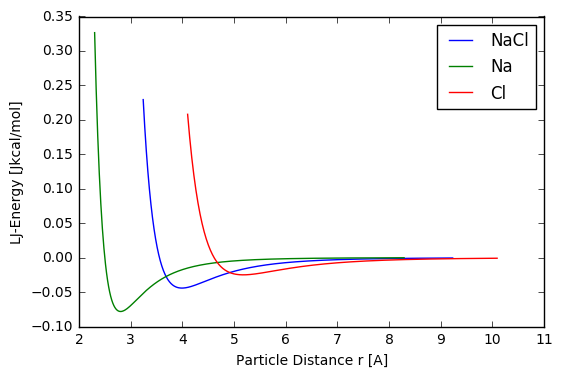

In [8]:
Image(filename='LJ_Potential.png')

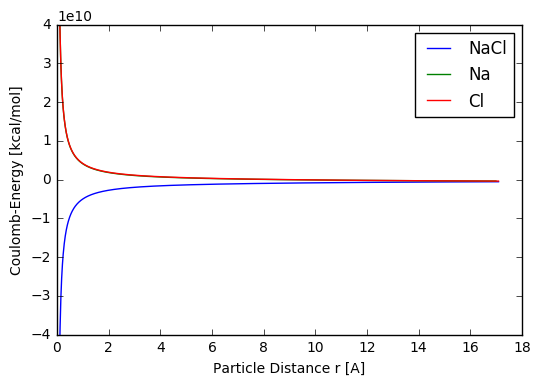

In [6]:
Image(filename='Coulomb_Potential.png')

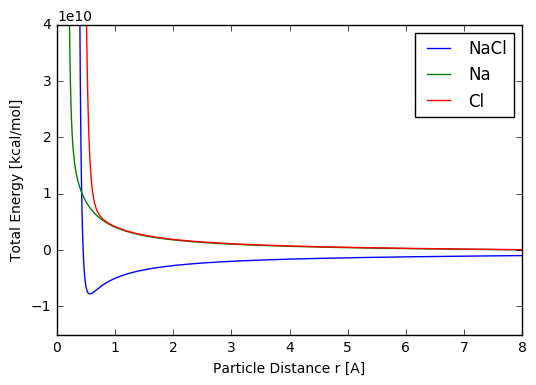

In [7]:
Image(filename='Total_Potential.png')

Make tests and measure computing time, talk about it, what happens, what is output, maybe show input as well, show video on vmd

maybe compute sth during presentation or prepare beforehand

Basically show off (=

# Outlook

- improve computing time by adding distance tensor ---> get rid of some for-loops

- some other shit